## Optymalizacja Zbieżności i Jakości Ścieżki: Algorytm RRT* ze Strategiami Wymiany Wag Inercji (AIW-LDIW)
### Metody Optymalizacji 2025
Paweł Rewilak, Mikołaj Sitko



Niniejszy projekt koncentruje się na dwupoziomowej optymalizacji algorytmu Rapidly-exploring Random Tree Star (RRT*), który jest powszechnie stosowany w planowaniu ścieżki (Path Planning) dla robotów mobilnych w złożonym środowisku.

Głównym celem jest rozwiązanie fundamentalnego kompromisu w RRT:

1. Optymalizacja Zbieżności (Szybkość): Poprzez wdrożenie Hybrydowych Adaptacyjnych Wag Inercji (AIW-LDIW), algorytm dynamicznie dostosowuje prawdopodobieństwo celowania w cel (Goal Bias) w zależności od aktualnego wskaźnika sukcesu i postępu iteracji. Prowadzi to do znacznego zwiększenia szybkości znajdowania wstępnej ścieżki i redukcji kosztu obliczeniowego.

2. Optymalizacja Jakości Ścieżki (Koszt): Zastosowanie algorytmu RRT* zapewnia, że niezależnie od metody próbkowania, końcowa trajektoria jest asymptotycznie optymalna (minimalizuje długość ścieżki euklidesowej) dzięki mechanizmom Select Best Parent i Rewire .

# Zastosowane optymalizacje

## Próbkowanie w Przestrzeni Elipsy (Elipse Sampling)
Standardowe RRT losuje węzły na całej przestrzeni. W celu zwiększenia wydajności i zbieżności, zwłaszcza w środowiskach z rozproszonymi przeszkodami, przestrzeń losowania ($X_{\text{rand}}$) została ograniczona do elipsy, której ogniskami są węzły Start i Cel .
Współrzędne losowego punktu w przestrzeni elipsy ($x_{\text{norm}}, y_{\text{norm}}$) uzyskuje się z losowo wybranego kąta $\phi$ i promienia $r$:

$$x_{\text{norm}} = a \cdot r \cdot \cos(\phi)$$

$$y_{\text{norm}} = b \cdot r \cdot \sin(\phi)$$

Gdzie $a$ i $b$ to półosie elipsy. Ostateczne współrzędne próbki $(X, Y)$ punkty te nalezało jeszcze poddać transformacji do globalnego układu (z uwzględnieniem obrotu $\theta$ i przesunięcia środka $(sr_x, sr_y)$)

## Adaptacyjne Sterowanie Wagami (AIW & LDIW)
W celu optymalizacji zbieżności algorytmu (minimalizacja liczby iteracji) w zależności od środowiska, zastosowano hybrydową strategię dynamicznego doboru wagi celu ($P_a$).

### 1. AIW - Adaptive Inertia Weight (Adaptacyjna Waga Inercji)
Mechanizm dostosowujący $P_a$ do lokalnej wydajności poprzez wskaźnik sukcesu ($P_s$ - stosunek udanych rozszerzeń). Gdy $P_s$ jest wysoki, zwiększa się dążenie do celu; gdy $P_s$ jest niski (np. w labiryncie), wymusza się eksplorację.

$$W_{AIW} = ((w_1 - w_2) \cdot P_s) + w_2$$

### 2. LDIW - Linear Decreasing Inertia Weight (Liniowo Malejąca Waga)
Mechanizm ten uzależnia wagę od upływu czasu (iteracji), wymuszając zmianę strategii z eksploracji na eksploatację pod koniec działania algorytmu.

$$W_{LDIW} = (w_1 - w_2) \cdot \frac{MAX_{itr} - Itr}{MAX_{itr}} + w_2$$

### 3. Hybrydowy Wzór na $P_a$ (Połączenie AIW i LDIW)
Ostateczny wzór na prawdopodobieństwo celowania w cel ($P_a$) jest kombinacją czynników adaptacyjnych (zależnych od sukcesu $P_S$) oraz czynnika czasu.

$$P_a = 1 - \left( \underbrace{\frac{P_{\max} - P_{\min}}{P_S}}_{\text{Czynnik AIW}} + \underbrace{\left( \frac{MAX_{itr} - Itr}{MAX_{itr}} \right)}_{\text{Czynnik Czasu}} \cdot \underbrace{\frac{P_{\min}}{P_S}}_{\text{Baza}} \right)$$



**Wyjaśnienie składników wzoru:**
Wzór ten można interpretować jako sumę dwóch filarów, ważoną przez upływ czasu:

1.  **Czynnik AIW (Dynamiczny):** $\frac{P_{\max} - P_{\min}}{P_S}$ – Ten człon reaguje na bieżącą skuteczność algorytmu ($P_S$). Jeśli algorytmowi idzie dobrze (duże $P_S$), mianownik rośnie, a odjemnik maleje, co zwiększa $P_a$ (bardziej celujemy w cel).

2.  **Czynnik Czasu (Time Factor):** $\frac{MAX_{itr} - Itr}{MAX_{itr}}$ – To element zapożyczony z LDIW. Jest to wartość od 1 (początek) do 0 (koniec).
    * Na początku działania algorytmu ten czynnik jest duży, co wzmacnia wpływ **Bazy** ($\frac{P_{\min}}{P_S}$), ograniczając $P_a$ i wymuszając eksplorację.
    * Z biegiem czasu czynnik ten maleje do 0, "wyłączając" dodatkowe ograniczenia i pozwalając algorytmowi skupić się na dotarciu do celu.

---

## Optymalizacja Jakości Ścieżki: Algorytm RRT*

Podczas gdy metody takie jak **Elipsa, AIW i LDIW** zajmują się optymalizacją **próbkowania** (czyli *gdzie* i *jak szybko* stawiamy nowe punkty), algorytm **RRT* (RRT Star)** zajmuje się optymalizacją **topologii drzewa** (czyli *jak* te punkty są ze sobą połączone).

**Kluczowa cecha:** RRT* jest rozszerzeniem działającym niezależnie od metody losowania. Oznacza to, że **każdy algorytm optymalizujący zbieżność (np. AIW-LDIW) może zostać wzbogacony o RRT***, aby uzyskać rozwiązanie, które jest nie tylko znalezione szybko, ale jest również najkrótsze (asymptotycznie optymalne).

### Jak działa RRT*?

W klasycznym RRT nowy węzeł ($X_{new}$) jest po prostu łączony z najbliższym sąsiadem. W RRT* proces ten jest rozbudowany o dwa kluczowe kroki optymalizacyjne, wykonywane w lokalnym promieniu sąsiedztwa ($r$):

#### A. Wybór Najlepszego Rodzica (Choose Best Parent)
Zamiast łączyć się z najbliższym węzłem, algorytm sprawdza wszystkich sąsiadów w promieniu $r$ i wybiera tego, który oferuje **najmniejszy łączny koszt** dotarcia od startu do $X_{new}$.

$$Cost(X_{new}) = \min_{X_{near} \in Near} (Cost(X_{near}) + Distance(X_{near}, X_{new}))$$



#### B. Przepinanie Gałęzi (Rewiring)
To najważniejszy krok RRT*. Po dodaniu $X_{new}$, algorytm sprawdza, czy nowy węzeł może posłużyć jako **skrót** dla swoich sąsiadów. Jeśli przejście przez $X_{new}$ jest tańsze niż dotychczasowa ścieżka sąsiada, połączenie jest "przepinane" (Rewire), a koszt aktualizowany kaskadowo w dół drzewa.

**Warunek przepięcia:**
$$Cost(X_{new}) + Distance(X_{new}, X_{near}) < Cost(X_{near})$$



### Podsumowanie synergii
W prezentowanym rozwiązaniu zastosowano pełną synergię:
1.  **AIW-LDIW + Elipsa:** Szybko eksplorują przestrzeń w kierunku celu (Redukcja liczby iteracji).
2.  **RRT*:** Dba o to, aby powstająca ścieżka była wygładzona i dążyła do linii prostej (Redukcja kosztu ścieżki).

## Wyniki przeprowadzonych testów

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 6)
plt.rcParams['font.size'] = 10

try:
    results_df = pd.read_pickle('rrt_benchmark_results.pkl')
    print("Wczytano dane z pliku: rrt_benchmark_results.pkl")
except FileNotFoundError:
    try:
        results_df = pd.read_csv('rrt_benchmark_results.csv')
        print("Wczytano dane z pliku: rrt_benchmark_results.csv")
    except FileNotFoundError:
        print("BŁĄD: Nie znaleziono pliku 'rrt_benchmark_results.pkl' ani 'rrt_benchmark_results.csv'. Uruchom najpierw skrypt testy.py.")
        results_df = pd.DataFrame()
        
if not results_df.empty:
    print(f"Wczytano {len(results_df)} rekordów.")

    successful_runs = results_df[results_df['Success'] == True].copy()

    order = [
        'RRT (Fixed)', 'RRT (AIW)', 'RRT (Hybrid)',
        'RRT* (Fixed)', 'RRT* (AIW)', 'RRT* (Hybrid)'
    ]
    successful_runs['Algorithm'] = pd.Categorical(successful_runs['Algorithm'], categories=order, ordered=True)

Wczytano dane z pliku: rrt_benchmark_results.pkl
Wczytano 540 rekordów.


In [ ]:
if not results_df.empty:
    summary = results_df.groupby(['Map', 'Algorithm']).agg(
        Mean_Iters=('Iterations', 'mean'),
        Mean_Cost=('Path_Cost', lambda x: x[x != float('inf')].mean()),
        Mean_Time_sec=('Time_sec', 'mean'),
        Success_Count=('Success', 'sum'),
        Total_Trials=('Success', 'count')
    ).reset_index()

    summary['Success_Rate (%)'] = (summary['Success_Count'] / summary['Total_Trials']) * 100
    summary = summary.drop(columns=['Success_Count', 'Total_Trials'])

    print("### Tabela 1: Średnie Wyniki Benchmarku (30 Prób na Mapę)")
    summary_styled = summary.style.format({
        'Mean_Iters': "{:.1f}",
        'Mean_Cost': "{:.1f}",
        'Mean_Time_sec': "{:.3f}",
        'Success_Rate (%)': "{:.1f}"
    }).hide(axis='index')
    
    display(summary_styled)

### Tabela 1: Średnie Wyniki Benchmarku (30 Prób na Mapę)


Map,Algorithm,Mean_Iters,Mean_Cost,Mean_Time_sec,Success_Rate (%)
mapa1,RRT (AIW),333.3,1655.1,0.011,100.0
mapa1,RRT (Fixed),1117.2,1539.7,0.018,73.3
mapa1,RRT (Hybrid),357.5,1662.6,0.013,100.0
mapa1,RRT* (AIW),332.7,1401.5,0.046,100.0
mapa1,RRT* (Fixed),1189.5,1406.5,0.090,70.0
mapa1,RRT* (Hybrid),306.3,1410.6,0.044,100.0
mapa2,RRT (AIW),391.0,1722.6,0.014,100.0
mapa2,RRT (Fixed),1391.0,1486.7,0.020,30.0
mapa2,RRT (Hybrid),434.7,1735.5,0.016,100.0
mapa2,RRT* (AIW),403.3,1505.2,0.060,100.0


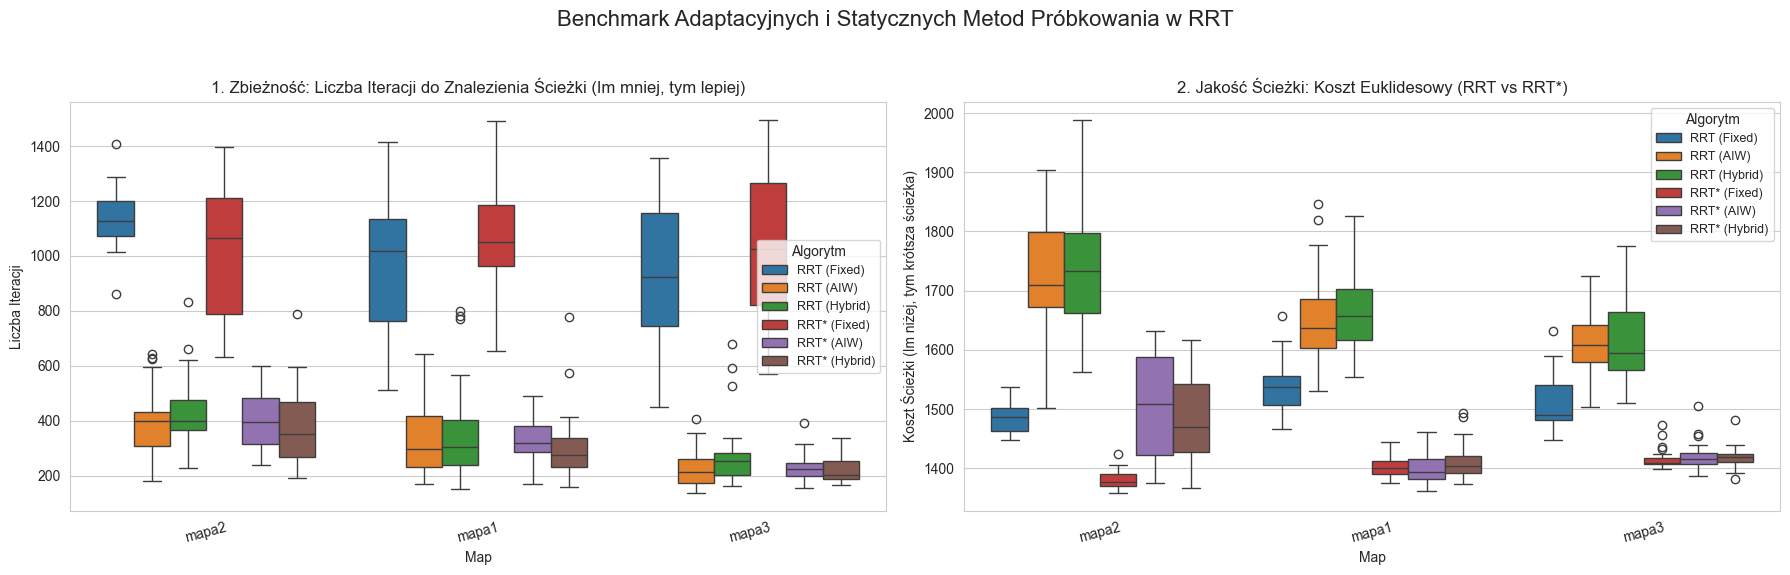

In [40]:
if not successful_runs.empty:
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # --- Wykres 1: Szybkość Zbieżności (Iterations) ---
    sns.boxplot(x='Map', y='Iterations', hue='Algorithm', data=successful_runs, ax=axes[0], palette="tab10")
    axes[0].set_title("1. Zbieżność: Liczba Iteracji do Znalezienia Ścieżki (Im mniej, tym lepiej)")
    axes[0].set_ylabel("Liczba Iteracji")
    axes[0].tick_params(axis='x', rotation=15)
    axes[0].legend(title="Algorytm", fontsize=9)

    # --- Wykres 2: Jakość Ścieżki (Path Cost) ---
    # ZMIANA: Teraz używamy 'successful_runs' (wszystkie algorytmy), a nie 'rrt_star_only'
    sns.boxplot(x='Map', y='Path_Cost', hue='Algorithm', data=successful_runs, ax=axes[1], palette="tab10") 
    
    # Zaktualizowany tytuł
    axes[1].set_title("2. Jakość Ścieżki: Koszt Euklidesowy (RRT vs RRT*)")
    axes[1].set_ylabel("Koszt Ścieżki (Im niżej, tym krótsza ścieżka)")
    axes[1].tick_params(axis='x', rotation=15)
    axes[1].legend(title="Algorytm", fontsize=9)

    plt.suptitle("Benchmark Adaptacyjnych i Statycznych Metod Próbkowania w RRT", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

## 📊 Wnioski Końcowe z Badań Symulacyjnych

Na podstawie przeprowadzonych badań symulacyjnych i analizy statystycznej porównującej algorytmy **RRT** oraz **RRT\*** w wariantach ze stałym parametrem celowania (**Fixed Goal Bias**) oraz z adaptacyjnym sterowaniem wagami (**AIW** i **Hybrid AIW-LDIW**), sformułowano następujące wnioski:

### 1. Dramatyczna Różnica w Zbieżności (Szybkość)
Wyniki jednoznacznie wskazują na ogromną przewagę metod adaptacyjnych pod względem szybkości znajdowania pierwszego rozwiązania.
* Warianty **AIW** i **Hybrid** potrzebowały średnio **4-5 razy mniej iteracji** niż warianty Fixed.
* **Przykład (Mapa 2):** Klasyczne RRT (Fixed) wymagało średnio **~1391 iteracji**, podczas gdy RRT (Hybrid) znajdowało ścieżkę już w **~434 iteracjach**.

> *Warianty adaptacyjne skutecznie eliminują problem "błądzenia" algorytmu w pustych przestrzeniach, dynamicznie zwiększając parcie na cel (Goal Bias), gdy jest to możliwe.*

### 2. Niezawodność (Success Rate)
* **Adaptacyjne sterowanie (AIW/Hybrid):** Zagwarantowało **100% skuteczności** na wszystkich testowanych mapach.
* **Stały parametr (Fixed):** Okazał się wysoce niestabilny. Na trudnej mapie 2 (z pułapkami typu U) skuteczność wyniosła zaledwie **30% dla RRT** i **56% dla RRT\***.

**Wniosek:** W niemal połowie przypadków klasyczny algorytm nie był w stanie znaleźć rozwiązania w zadanym limicie czasu.

### 3. Paradoks Jakości Ścieżki w RRT* (Fixed vs Adaptive)
Analiza kosztu ścieżki (*Path Cost*) po zastosowaniu optymalizacji RRT* ujawniła interesujące zjawisko:
* Ogólnie różnice w długości ścieżek między wariantami Fixed a Adaptive były niewielkie (rzędu 5%).
* Zaskakująco, **RRT* (Fixed) często generował ścieżki o niższym koszcie** (krótsze) niż jego szybsze odpowiedniki.
* Najbardziej widoczne było to na mapie 2, gdzie RRT* (Fixed) osiągnął średni koszt **~1382**, podczas gdy RRT* (Hybrid) **~1482** (różnica ok. 7%).

### 4. Wyjaśnienie Fenomenu Mapy 2: "Wolniej znaczy Dokładniej"
Lepsza jakość ścieżki w wariancie Fixed na mapie 2 wynika bezpośrednio z jego powolnej zbieżności.
1.  Ponieważ **RRT* (Fixed)** potrzebował średnio aż 1235 iteracji na znalezienie celu (w porównaniu do 380 dla Hybrid), wygenerował on **3-krotnie gęstsze drzewo**.
2.  Większa liczba węzłów w przestrzeni dała mechanizmowi **Rewire** (przepinanie gałęzi) znacznie więcej okazji do optymalizacji i skracania ścieżki.

> **Trade-off:** Wariant Fixed oferuje nieco lepszą jakość ścieżki, ale kosztem ogromnego nakładu obliczeniowego i bardzo niskiej niezawodności.

---

### 🏆 5. Synergia i Rekomendacja (Najlepsze Rozwiązanie)

Biorąc pod uwagę wszystkie czynniki (czas, jakość, niezawodność), **RRT* (Hybrid)** jest rozwiązaniem optymalnym dla rzeczywistych zastosowań robotycznych:

*  Dla każdej z map zapewniało **100% pewności** znalezienia ścieżki.
*  Jest **4-5 razy szybszy** od klasycznego RRT*.
*  Generuje ścieżki tylko minimalnie gorsze (o ok. 5-7%) od wariantu Fixed, co jest akceptowalną ceną za drastyczny wzrost szybkości i stabilności działania.

Bibliografia (References)


https://www.nature.com/articles/s41598-025-87113-5

https://theclassytim.medium.com/robotic-path-planning-rrt-and-rrt-212319121378

https://ieeexplore.ieee.org/document/9935450

https://pmc.ncbi.nlm.nih.gov/articles/PMC3833296/
